<a href="https://colab.research.google.com/github/Sakina8/Sarcasm-Detection-1/blob/master/SarcDeepL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Sarcasm - To be continued by Sakina Hajiyeva

Here I decided to continue my investigation on sarcasm detection and thought to myself why not to use Deep learning with Tensorflow just to make sure the process is quicker and with higher quality.

In [0]:
#But before that I should import libraries and make some small preprocessing in this notebook

import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
#Gonna bring the dataset here

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train-balanced-sarcasm.csv to train-balanced-sarcasm.csv
User uploaded file "train-balanced-sarcasm.csv" with length 255268960 bytes


In [0]:
data = pd.read_csv('train-balanced-sarcasm.csv')
data

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [0]:
data.shape

(1010826, 10)

In [0]:
data['label'].value_counts()

1    505413
0    505413
Name: label, dtype: int64

In [0]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [0]:
# let's divide dataset into train, cv, and test
data_pos_tr = data_pos.iloc[:450000]

data_pos_cv = data_pos_tr.iloc[400000:450000]
data_pos_tr = data_pos_tr.iloc[:400000]

data_pos_test = data_pos.iloc[450000:500000]

data_neg_tr = data_neg.iloc[:450000]

data_neg_cv = data_neg_tr.iloc[400000:450000]
data_neg_tr = data_neg_tr.iloc[:400000]

data_neg_test = data_neg.iloc[450000:500000]

In [0]:
data_tr = pd.concat([data_pos_tr, data_neg_tr])
data_cv = pd.concat([data_pos_cv, data_neg_cv])
data_test = pd.concat([data_pos_test, data_neg_test])

In [0]:
# let's see the result

print('Shape of train data: {}'.format(data_tr.shape))
print('Shape of CV data: {}'.format(data_cv.shape))
print('Shape of test data: {}'.format(data_test.shape))

Shape of train data: (800000, 10)
Shape of CV data: (100000, 10)
Shape of test data: (100000, 10)


In [0]:
data_tr.to_csv('train.csv', index=False)
data_cv.to_csv('cv.csv', index=False)
data_test.to_csv('test.csv', index=False)

In [0]:
# This time I'll clean the data quickly

#importing libraries coz I can be very forgetful

import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import math
import pickle
import os

from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
import gensim

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [0]:
train = pd.read_csv('train.csv')
cv = pd.read_csv('cv.csv')
test = pd.read_csv('test.csv')

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           800000 non-null  int64 
 1   comment         799972 non-null  object
 2   author          800000 non-null  object
 3   subreddit       800000 non-null  object
 4   score           800000 non-null  int64 
 5   ups             800000 non-null  int64 
 6   downs           800000 non-null  int64 
 7   date            800000 non-null  object
 8   created_utc     800000 non-null  object
 9   parent_comment  800000 non-null  object
dtypes: int64(4), object(6)
memory usage: 61.0+ MB


In [0]:
train.shape

(800000, 10)

In [0]:
train['label'].value_counts()

1    400000
0    400000
Name: label, dtype: int64

In [0]:
len(train['subreddit'].unique())

13432

In [0]:
train[train['label'] == 1]['subreddit'].value_counts()[:20]

AskReddit          20088
politics           18080
worldnews          12470
pcmasterrace        9671
leagueoflegends     9333
news                8495
GlobalOffensive     7251
nba                 5831
nfl                 5815
todayilearned       5514
pics                4984
funny               4853
AdviceAnimals       4614
The_Donald          4458
videos              4350
TumblrInAction      3861
hockey              3797
gaming              3570
soccer              3361
CFB                 2730
Name: subreddit, dtype: int64

There are a total of 13432 different subreddits in our dataset.
Top 20 subreddits having sarcastic comments include AskReddit, politics, worldnews, etc.

In [0]:
len(train['author'].unique())

228956

In [0]:
train[train['label'] == 1]['author'].value_counts()[:20]

Biffingston          219
pokemon_fetish       213
ShyBiDude89          187
NeonDisease          179
ivsciguy             161
mad-n-fla            150
mindlessrabble       129
sleaze_bag_alert     125
Chaoslab             123
JumpingJazzJam        97
DownvoteDaemon        94
EMINEM_4Evah          92
richardleosimones     84
InFearn0              82
TouchMeHerePls        79
kurisu7885            77
tau-lepton            76
Canada_girl           72
ozric101              72
hookyboysb            71
Name: author, dtype: int64

In [0]:
pip install Unidecode

     |████████████████████████████████| 245kB 1.8MB/s 


In [0]:
import re
import sys

In [0]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
 

In [0]:
def removeLinks(text):
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return text

def removeHTMLTags(text):
    text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
    return text

def convertToLowerCase(text):
    return text.lower()

def removeWordsWithNumbers(text):
    return re.sub(r'\S*\d\S*', '', text).strip()

def removePuctuations(text):
    return re.sub(r'[^A-Za-z0-9]+', ' ', text)

def removeWhiteSpaces(text):
    return text.strip()

def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [0]:

def clean_data(text):
    
    text = str(text)
    text = removeLinks(text)
    text = removeHTMLTags(text)
    text = convertToLowerCase(text)
    text = removeWordsWithNumbers(text)
    text = removeWhiteSpaces(text)
    text = decontracted(text)
    text = removePuctuations(text)
    text = remove_emoji(text)
    text = text.strip()
    
    return text

In [0]:
cleaned_train = train.dropna(how='any', axis=0)
cleaned_train['comment'] = cleaned_train['comment'].apply(clean_data)
cleaned_train['author'] = cleaned_train['author'].apply(removeWhiteSpaces)

cleaned_cv = cv.dropna(how='any', axis=0)
cleaned_cv['comment'] = cleaned_cv['comment'].apply(clean_data)
cleaned_cv['author'] = cleaned_cv['author'].apply(removeWhiteSpaces)

cleaned_test = test.dropna(how='any', axis=0)
cleaned_test['comment'] = cleaned_test['comment'].apply(clean_data)
cleaned_test['author'] = cleaned_test['author'].apply(removeWhiteSpaces)

In [0]:
#testing
train['comment'].iloc[56]

"you know, if I were a pro, I'd practice 16 hours a day for 5 years straight, especially after single handedly throwing the world championship away after being carried to the group stage."

In [0]:
#testing
cleaned_train['comment'].iloc[56]

'you know if i were a pro i would practice hours a day for years straight especially after single handedly throwing the world championship away after being carried to the group stage'

In [0]:
cleaned_train['comment'] = cleaned_train['comment'].astype(str)
cleaned_cv['comment'] = cleaned_cv['comment'].astype(str)
cleaned_test['comment'] = cleaned_test['comment'].astype(str)

cleaned_train['author'] = cleaned_train['author'].astype(str)
cleaned_cv['author'] = cleaned_cv['author'].astype(str)
cleaned_test['author'] = cleaned_test['author'].astype(str)

In [0]:
cleaned_train.to_csv('train.csv', index=None)
cleaned_cv.to_csv('cv.csv', index=None)
cleaned_test.to_csv('test.csv', index=None)

In [0]:
# Ta-Daaaa, time for modeling phase!!

#importing libraries

from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

import keras
from keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow as tf

import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [0]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [0]:
train = pd.read_csv('train.csv')
cv = pd.read_csv('cv.csv')
test = pd.read_csv('test.csv')

#Checking if it's clean as I saved it
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,but they will have all those reviews,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
1,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
2,1,ho ho ho but melania said that there is no way...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
3,1,i can not wait until potus starts a twitter wa...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
4,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


In [0]:
train['label'].value_counts()

0    399994
1    399978
Name: label, dtype: int64

In [0]:
test['label'].value_counts()

0    49999
1    49984
Name: label, dtype: int64

In [0]:
train['comment'] = train['comment'].astype(str)
cv['comment'] = cv['comment'].astype(str)
test['comment'] = test['comment'].astype(str)

train['author'] = train['author'].astype(str)
cv['author'] = cv['author'].astype(str)
test['author'] = test['author'].astype(str)

In [0]:
t = Tokenizer()
t.fit_on_texts(train['comment'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

138775


In [0]:
encoded_comments_train = t.texts_to_sequences(train['comment'])
encoded_comments_cv = t.texts_to_sequences(cv['comment'])
encoded_comments_test = t.texts_to_sequences(test['comment'])

In [0]:
lengths = []

for doc in encoded_comments_train:
    lengths.append(len(doc))

In [0]:
np.percentile(lengths, 99.9)

66.0

In [0]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [0]:
y_train = train['label'].values
y_cv = cv['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [0]:
w2v_model = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [0]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(138775, 300)

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Model 1 - Baseline**

In [0]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 70)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 300)           41632500  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 67, 50)            60050     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 33, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 31, 100)           15100     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 100)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1500)              0   

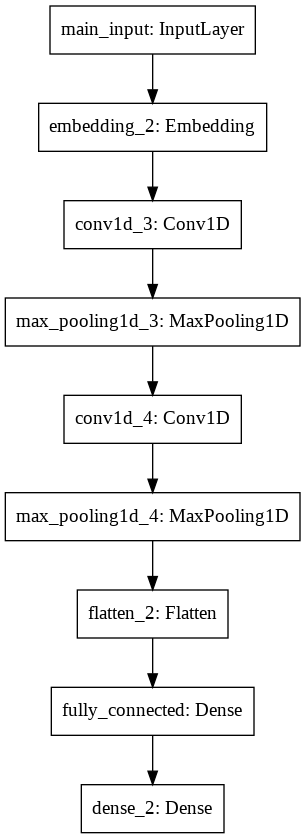

In [0]:

keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [0]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 10,
                            verbose=1)

In [0]:
c = optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=2, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

Train on 799972 samples, validate on 99994 samples
Epoch 1/50
 - 520s - loss: 0.4997 - f1_m: 0.7533 - acc: 0.7533 - val_loss: 0.5591 - val_f1_m: 0.7162 - val_acc: 0.7162

Epoch 00001: val_f1_m improved from -inf to 0.71621, saving model to model_01.h5
Epoch 2/50
 - 515s - loss: 0.4957 - f1_m: 0.7562 - acc: 0.7562 - val_loss: 0.5595 - val_f1_m: 0.7161 - val_acc: 0.7161

Epoch 00002: val_f1_m did not improve from 0.71621
Epoch 3/50
 - 514s - loss: 0.4917 - f1_m: 0.7594 - acc: 0.7594 - val_loss: 0.5639 - val_f1_m: 0.7132 - val_acc: 0.7132

Epoch 00003: val_f1_m did not improve from 0.71621
Epoch 4/50
 - 518s - loss: 0.4880 - f1_m: 0.7620 - acc: 0.7620 - val_loss: 0.5702 - val_f1_m: 0.7122 - val_acc: 0.7122

Epoch 00004: val_f1_m did not improve from 0.71621
Epoch 5/50
 - 512s - loss: 0.4845 - f1_m: 0.7645 - acc: 0.7645 - val_loss: 0.5627 - val_f1_m: 0.7163 - val_acc: 0.7163

Epoch 00005: val_f1_m improved from 0.71621 to 0.71628, saving model to model_01.h5
Epoch 6/50
 - 526s - loss: 0.48